# Binary Classification with Neural Networks

Binary classification is a supervised learning task where the goal is to classify inputs into one of two classes. A neural network consists of an input layer that receives feature values (X1, X2), hidden layers that learn intermediate representations, and an output layer that produces a single logit for classification.

Non-linear datasets such as the circles dataset cannot be separated using linear models alone. Activation functions like ReLU introduce non-linearity, enabling the network to learn complex decision boundaries.

BCEWithLogitsLoss is used as the loss function, as it combines sigmoid activation and binary cross-entropy in a numerically stable way. The model outputs raw logits, which are converted to probabilities using the sigmoid function during evaluation.


### Data Retrival & Inspection

In [2]:
import numpy as np
import torch
import pandas as pd

data = pd.read_csv('./circles_binary_classification.csv')
print(data.head())
print(data.describe())

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


### Data cleaning & feature design

Checking for null values and data types.

In [3]:
print(data.isnull().sum())
print(data.dtypes)

X1       0
X2       0
label    0
dtype: int64
X1       float64
X2       float64
label      int64
dtype: object


In [4]:
X = data[['X1', 'X2']].values  
y = data['label'].values       

# converting it into torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (N,1) for BCE

#finally checking the shape of tensor
print(X_tensor.shape, y_tensor.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


### Visualization 

Scatter plot X and Y.

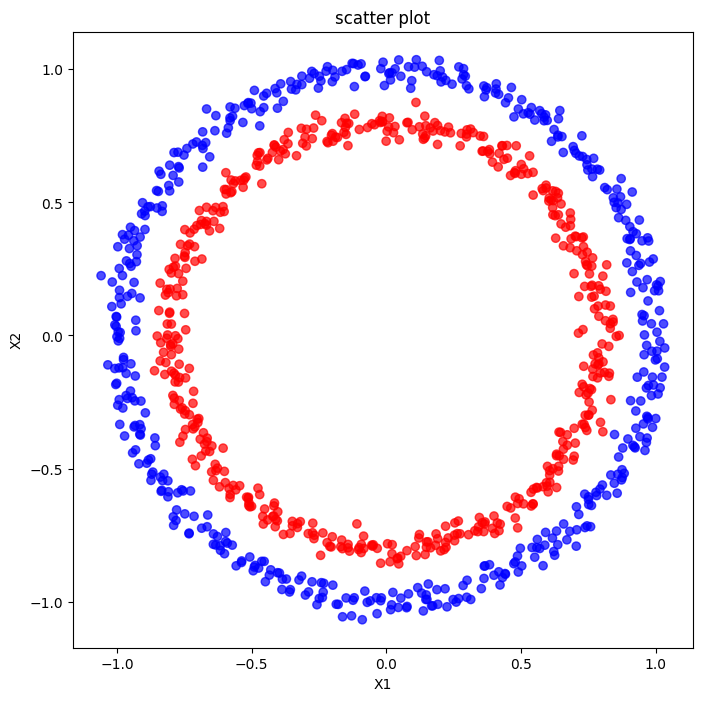

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.7)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('scatter plot')
plt.show()

### Test/train split


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)


### Device & dtype

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

### Implement baseline models

In [9]:
from torch import nn


class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

In [10]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 15)
        self.layer_2 = nn.Linear(15, 15)
        self.layer_3 = nn.Linear(15, 1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [11]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 10)
        self.layer_4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x

### Loss, Optimizer, Metrics

In [12]:
loss_fn = nn.BCEWithLogitsLoss()

def accuracy(logits, labels):
    preds = torch.round(torch.sigmoid(logits))
    return (preds == labels).float().mean()

### Training Loop & Evaluation

In [13]:
def train_and_eval(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.1):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}
    
    for epoch in range(1, epochs+1):
        # Train step
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()
        train_acc = accuracy(logits, y_train)
        
        # Eval step
        model.eval()
        with torch.no_grad():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy(test_logits, y_test)
        
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc.item())
        history['test_loss'].append(test_loss.item())
        history['test_acc'].append(test_acc.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")
    
    return model, history

#### Model 0

In [14]:
model_v0 = ModelV0().to(device)

model_v0.eval()
with torch.no_grad():
    untrained_logits = model_v0(X_train)
    print("Untrained predictions (first 10):", torch.sigmoid(untrained_logits[:10]).cpu().numpy())


Untrained predictions (first 10): [[0.54652107]
 [0.5460108 ]
 [0.48924983]
 [0.49082616]
 [0.51672894]
 [0.4939937 ]
 [0.50946116]
 [0.54336804]
 [0.5024033 ]
 [0.554213  ]]


In [15]:
model_v0, history_v0 = train_and_eval(model_v0, X_train, y_train, X_test, y_test, epochs=100, lr=0.1)

Epoch 10: Train Loss=0.6939, Train Acc=0.5250, Test Acc=0.4950
Epoch 20: Train Loss=0.6936, Train Acc=0.5200, Test Acc=0.4800
Epoch 30: Train Loss=0.6934, Train Acc=0.5138, Test Acc=0.4800
Epoch 40: Train Loss=0.6934, Train Acc=0.5088, Test Acc=0.4800
Epoch 50: Train Loss=0.6933, Train Acc=0.5100, Test Acc=0.4800
Epoch 60: Train Loss=0.6932, Train Acc=0.5050, Test Acc=0.4800
Epoch 70: Train Loss=0.6932, Train Acc=0.5088, Test Acc=0.4650
Epoch 80: Train Loss=0.6932, Train Acc=0.5025, Test Acc=0.4700
Epoch 90: Train Loss=0.6931, Train Acc=0.5088, Test Acc=0.4700
Epoch 100: Train Loss=0.6931, Train Acc=0.5100, Test Acc=0.4750


In [16]:
model_v0.eval()
with torch.no_grad():
    trained_logits = model_v0(X_train)
    print("Trained predictions (first 10):", torch.sigmoid(trained_logits[:10]).cpu().numpy())

Trained predictions (first 10): [[0.5060361 ]
 [0.5013409 ]
 [0.48098025]
 [0.4801578 ]
 [0.5107915 ]
 [0.47788328]
 [0.5052565 ]
 [0.52042073]
 [0.50282776]
 [0.50932   ]]


In [17]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].cpu().numpy().min()-0.5, X[:,0].cpu().numpy().max()+0.5
    y_min, y_max = X[:,1].cpu().numpy().min()-0.5, X[:,1].cpu().numpy().max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(grid)
        preds = torch.round(torch.sigmoid(logits)).cpu().numpy()
    
    Z = preds.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.6, cmap='bwr')
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap='bwr', edgecolor='k')
    plt.show()

def plot_loss(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.show()

Decision boundary - V0 (Train)


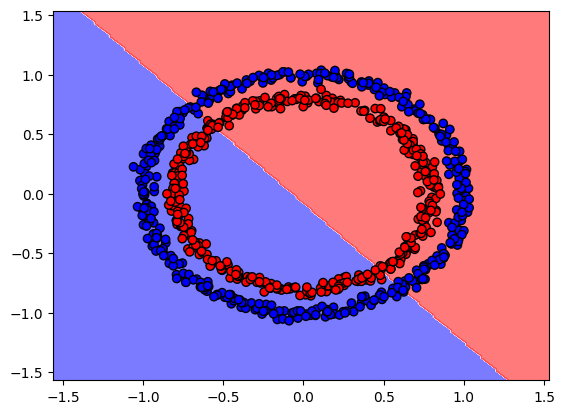

Decision boundary - V0 (Test)


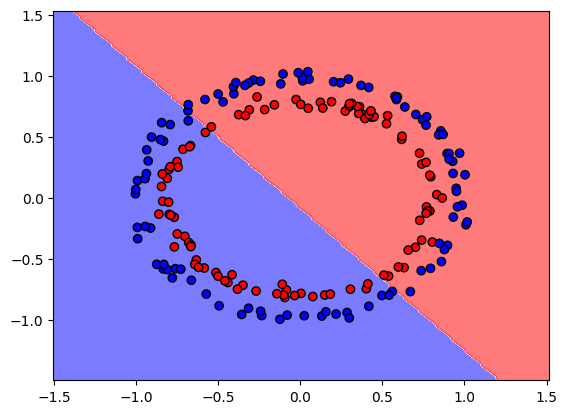

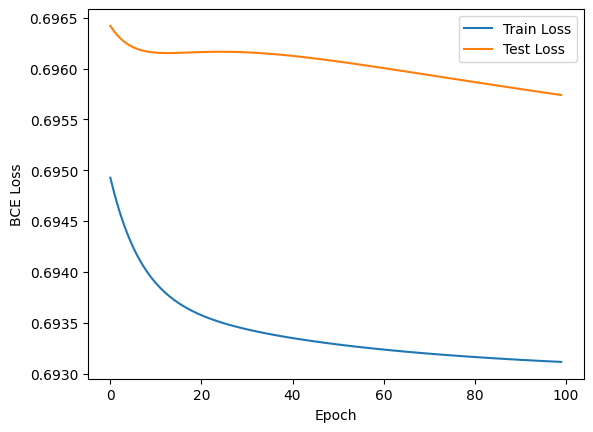

In [18]:
# Decision boundaries
print("Decision boundary - V0 (Train)")
plot_decision_boundary(model_v0, X_train, y_train)

print("Decision boundary - V0 (Test)")
plot_decision_boundary(model_v0, X_test, y_test)

# Loss curves
plot_loss(history_v0)

### Model 1

In [19]:
model_v1 = ModelV1().to(device)

# Untrained predictions
model_v1.eval()
with torch.no_grad():
    untrained_logits = model_v1(X_train)
    print("Untrained predictions (first 10):", torch.sigmoid(untrained_logits[:10]).cpu().numpy())

Untrained predictions (first 10): [[0.34563708]
 [0.32473087]
 [0.54372555]
 [0.5296626 ]
 [0.54709125]
 [0.49776226]
 [0.55936635]
 [0.44123137]
 [0.58744454]
 [0.32063466]]


In [20]:
# Training
model_v1, history_v1 = train_and_eval(model_v1, X_train, y_train, X_test, y_test, epochs=1000, lr=0.1)

Epoch 10: Train Loss=0.7013, Train Acc=0.4938, Test Acc=0.5100
Epoch 20: Train Loss=0.6967, Train Acc=0.4925, Test Acc=0.5000
Epoch 30: Train Loss=0.6948, Train Acc=0.4950, Test Acc=0.5100
Epoch 40: Train Loss=0.6939, Train Acc=0.4975, Test Acc=0.5050
Epoch 50: Train Loss=0.6935, Train Acc=0.5013, Test Acc=0.5000
Epoch 60: Train Loss=0.6933, Train Acc=0.5025, Test Acc=0.5150
Epoch 70: Train Loss=0.6931, Train Acc=0.4975, Test Acc=0.4950
Epoch 80: Train Loss=0.6931, Train Acc=0.5038, Test Acc=0.4750
Epoch 90: Train Loss=0.6930, Train Acc=0.5000, Test Acc=0.4800
Epoch 100: Train Loss=0.6930, Train Acc=0.5063, Test Acc=0.4700
Epoch 110: Train Loss=0.6930, Train Acc=0.5075, Test Acc=0.4550
Epoch 120: Train Loss=0.6930, Train Acc=0.5088, Test Acc=0.4600
Epoch 130: Train Loss=0.6930, Train Acc=0.5063, Test Acc=0.4600
Epoch 140: Train Loss=0.6930, Train Acc=0.5125, Test Acc=0.4800
Epoch 150: Train Loss=0.6930, Train Acc=0.5088, Test Acc=0.4700
Epoch 160: Train Loss=0.6930, Train Acc=0.5075, T

In [21]:
# trained predictions
model_v1.eval()
with torch.no_grad():
    trained_logits = model_v1(X_train)
    print("Trained predictions (first 10):", torch.sigmoid(trained_logits[:10]).cpu().numpy())

Trained predictions (first 10): [[0.49797696]
 [0.49428368]
 [0.4926973 ]
 [0.49160925]
 [0.50975764]
 [0.48891523]
 [0.50716394]
 [0.5105555 ]
 [0.50704736]
 [0.49860343]]


Decision boundary - V1 (Train)


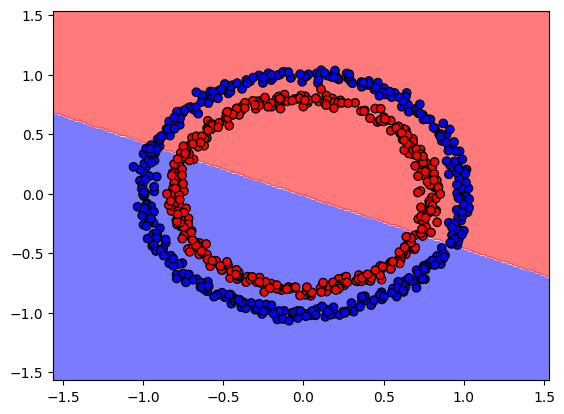

Decision boundary - V1 (Test)


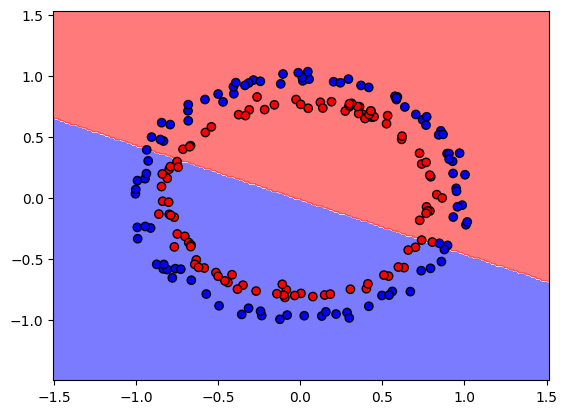

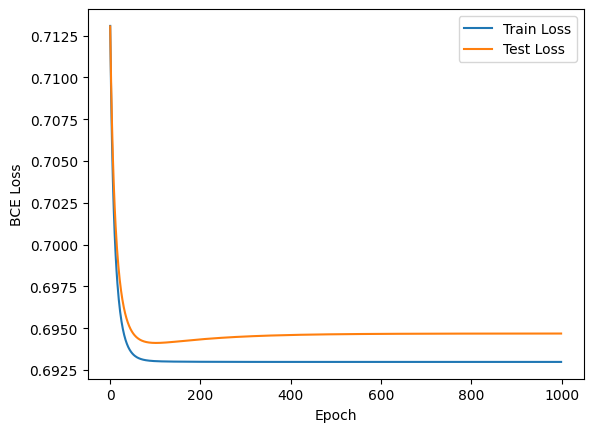

In [23]:
# Decision boundaries
print("Decision boundary - V1 (Train)")
plot_decision_boundary(model_v1, X_train, y_train)

print("Decision boundary - V1 (Test)")
plot_decision_boundary(model_v1, X_test, y_test)

# Loss curves
plot_loss(history_v1)

#### Model 2

In [29]:
model_v2 = ModelV2().to(device)

# untrained predictions
model_v2.eval()
with torch.no_grad():
    untrained_logits = model_v2(X_train)
    print("Untrained predictions (first 10):", torch.sigmoid(untrained_logits[:10]).cpu().numpy())

Untrained predictions (first 10): [[0.5488008 ]
 [0.5500779 ]
 [0.5418021 ]
 [0.5428684 ]
 [0.54641634]
 [0.545143  ]
 [0.5447762 ]
 [0.5447331 ]
 [0.5424268 ]
 [0.54845405]]


In [30]:
# Training
model_v2, history_v2 = train_and_eval(model_v2, X_train, y_train, X_test, y_test, epochs=1000, lr=0.1)

Epoch 10: Train Loss=0.6942, Train Acc=0.5000, Test Acc=0.5000
Epoch 20: Train Loss=0.6927, Train Acc=0.5000, Test Acc=0.5000
Epoch 30: Train Loss=0.6918, Train Acc=0.5000, Test Acc=0.5000
Epoch 40: Train Loss=0.6911, Train Acc=0.5375, Test Acc=0.5350
Epoch 50: Train Loss=0.6906, Train Acc=0.5975, Test Acc=0.5800
Epoch 60: Train Loss=0.6902, Train Acc=0.6463, Test Acc=0.6750
Epoch 70: Train Loss=0.6897, Train Acc=0.7138, Test Acc=0.7400
Epoch 80: Train Loss=0.6893, Train Acc=0.6900, Test Acc=0.7450
Epoch 90: Train Loss=0.6887, Train Acc=0.7100, Test Acc=0.7500
Epoch 100: Train Loss=0.6882, Train Acc=0.6800, Test Acc=0.7150
Epoch 110: Train Loss=0.6877, Train Acc=0.6538, Test Acc=0.6900
Epoch 120: Train Loss=0.6871, Train Acc=0.6625, Test Acc=0.6950
Epoch 130: Train Loss=0.6865, Train Acc=0.6825, Test Acc=0.7050
Epoch 140: Train Loss=0.6859, Train Acc=0.6975, Test Acc=0.7150
Epoch 150: Train Loss=0.6851, Train Acc=0.7188, Test Acc=0.7250
Epoch 160: Train Loss=0.6843, Train Acc=0.7212, T

In [31]:
#trained predictions
model_v2.eval()
with torch.no_grad():
    trained_logits = model_v2(X_train)
    print("Trained predictions (first 10):", torch.sigmoid(trained_logits[:10]).cpu().numpy())

Trained predictions (first 10): [[9.9664235e-01]
 [1.6826043e-02]
 [5.6418841e-04]
 [3.1226836e-03]
 [9.9378270e-01]
 [1.4802599e-03]
 [9.9693346e-01]
 [9.9879551e-01]
 [1.1672308e-02]
 [8.7279902e-04]]


Decision boundary - V2 (Train)


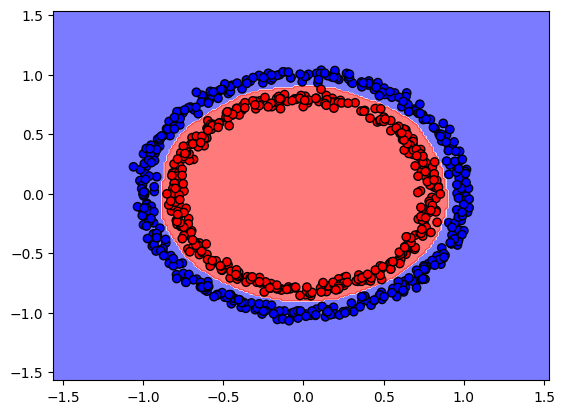

Decision boundary - V2 (Test)


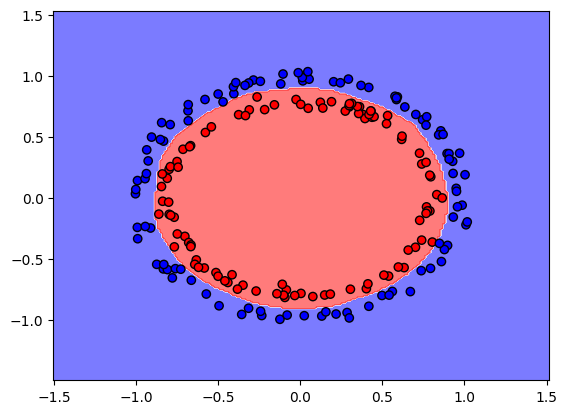

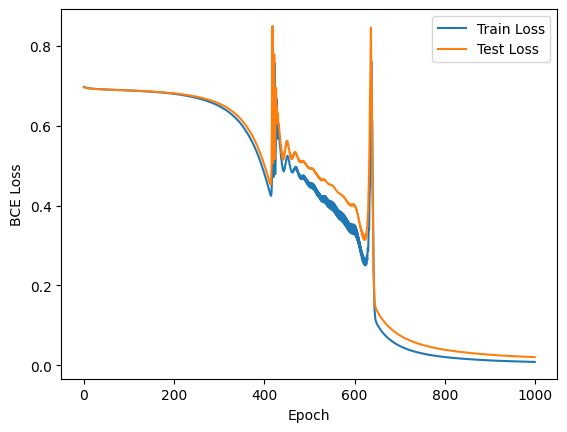

In [32]:
# Decision boundaries
print("Decision boundary - V2 (Train)")
plot_decision_boundary(model_v2, X_train, y_train)

print("Decision boundary - V2 (Test)")
plot_decision_boundary(model_v2, X_test, y_test)

# Loss curves
plot_loss(history_v2)

### Discussion

This experiment evaluated different neural network models for binary classification on circular data. Model V0 and Model V1 which lacked non-linear activation functions performed poorly. Model V1 performed relatively better due to the increased neurons and hidden layers.

Model V2, which incorporated ReLU activations and greater depth, significantly improved classification accuracy. The non-linear activations enabled the network to learn complex spatial relationships present in the dataset. Loss curves showed smoother convergence as well.

### Conclusion

Overall, in this experiment, multiple PyTorch neural network models were implemented and compared for binary classification on a circular dataset. Results clearly showed that shallow or purely linear models are inadequate for non-linear classification tasks such as this. Introducing non-linear activation functions and more neurons significantly improved performance with Model V2 achieving the best performance and accuracy.